In [35]:
# packages
import pandas as pd
import numpy as np

from claspy.segmentation import BinaryClaSPSegmentation

import ruptures as rpt

import stumpy
from aeon.segmentation import find_dominant_window_sizes

from aeon.segmentation import GreedyGaussianSegmenter

from aeon.segmentation import InformationGainSegmenter

from aeon.anomaly_detection import STRAY

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer,mean_squared_error
import matplotlib.pyplot as plt
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from claspy.tests.evaluation import f_measure,covering

In [2]:
# Questi sono tutte le features estratte
# kineticglobal,kineticchest,directnesshead,density,leftwristke,rightwristke,leftankleke,rightankleke,headke,posturaltension

# Queste sono le feature che utilizzeremo
# kineticglobal, density, leftwirstke, rightwristke, leftankleke, rightankleke, headke, posturaltension
# che corrispondono
# 2,4,5,6,7,8,9,10,11
# Questa funzione legge il file di input e restituisce un dataframe con i dati preprocessati
def ReadAndPreProcess(inputDataRaw):
    # lettura
    df=pd.read_csv(inputDataRaw,sep=' ', header=None)
    df.drop(0, axis=1)
    df["som"]=df.sum(axis=1)
    ## preprocessing

    # dealing NaN values
    #-serafino ha usato forward fill, backward fill, linear interpolation
    #-ricordo che serafino aveva gia utilizzato sta cosa sui dati grezzi non sulle feature ma sui dati prefeature percio dovrebbe essere gia apposto

    # downsampling
    #-sono a 100ms, non sò se devo scendere a 50ms. da decidere

    # low pass filter
    #-Skogstad and colleagues (2013) e https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    #-implementare dopo

    # remove outliers
    #-utilizzare hampel filter

    # stretch
    #-forse devo stretcharlo come ho fatto precedentemente
    #-anche se nel codice precedente ho stretchato solo il groundtruth

    # ritorno un oggetto dataframe dopo che è stato lavorato, ottenendo un prodotto lavorato
    return df


In [3]:
# questa funzione ritorna un dataframe del groundtruth che viene usato specificatamente per visualizzare il gt
# è soggetto a un preprocessing dei dati siccome l'ultimo groundtruth è dove termina il ts del gt
# di conseguenza per farlo corrispondere, bisogna stretcharlo
# ma ricordo di aver rifatti i dati nuovi per generare un groundtruth a fine ts, da controllare cosi che non serve stretcharlo?
def LoadingGroundTruth(df,gtraw):
    gt=pd.read_csv(gtraw,sep=' ', header=None)
    gt=gt.iloc[:,0].values
    #stretching dei dati se necessario per farlo corrispondere alla ts dei dati
    stretch_gt = np.array([])
    for idx,i in enumerate(gt):
        relpos = len(df)*i/gt[-1]
        stretch_gt = np.append(stretch_gt,relpos)

    # eliminiamo l'ultimo elemento che è stato annotato solo per delimitare la lunghezza della gt simile alla ts
    return stretch_gt[:-1]

In [4]:
def test(test, **kwargs):
    return BinaryClaSPSegmentation(**kwargs)

asd=test("asd",window_size="fft",distance="euclidean_distance")
print(asd.window_size)
print(asd.distance)

fft
euclidean_distance


In [5]:
# utilizzo CLASP 
# prende come parametro un dataframe e restituisce il clasp score
# gt e known vengono usati per usare il numero vero di cp se uguale a 1 sennò si cerca di predirlo se il modello lo permette
def GetClasp(df,gt,known, **kwargs):
    #result=np.array([])
    result=np.array([])
    eachresult = []
    for idx,i in enumerate([4]):
      
        ts=df.iloc[:,i]

        if known == 1:
            print("knwon!")
            clasp = BinaryClaSPSegmentation(n_segments=len(gt), validation=None)
        else:
            print("unknown!")
            clasp = BinaryClaSPSegmentation(**kwargs)
            
        found_cps = clasp.fit_predict(ts.values)    

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        # per ogni array di cp di ogni singola feature
        # li unisco in un unico array. in pratica faccio un OR di tutti i cp
        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)
        
        

        
    return result, eachresult, clasp
        
    


In [6]:
def PlotResult(df,gt,cp,eachcp,ts):
    #da testare quando ho piu valori
    #clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

        
    for idx,i in enumerate([4]):
  
        # idx == 8 è l'ultimo elemento. percio quando i è uguale a 11
        # significa che l'ultimo elemento del mio for è la ts totale di tutte le feature
        if idx == 8:
            plt.figure(figsize=(18,9))
            plt.plot(np.arange(len(df["som"].values)),df["som"].values,'blue',linewidth=0.5)
            for idx2,j in enumerate(gt.astype(int)):

                plt.axvline(x = j, color = 'green',linewidth=1) 

            for j in cp.tolist():
                plt.axvline(x = j, color = 'black',linewidth=1) 
        else:


            
            _ = plot_series_with_change_points(df.iloc[:,i], eachcp[idx], title=str(ts)+"prediction number: "+str(i))
            for idx2,j in enumerate(gt.astype(int)):
                plt.axvline(x = j, color = 'green',linewidth=1) 


In [7]:
def Plotclasp(clasp,gt):
    clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

In [36]:
# calcola i vari scores dati il groundtruth e il prediction
# puo salvare il risultato su file per evitare di perderli
# prende come parametro nome del groundtruth, groundtruth, nome della timeseries e il prediction
def Evaluate(modelName,gtName, gt, tsName, cp, df):
    # creo dei array di lunghezza come la ts cosi possono fare il confronto
    # sia per il gt che per il pd
  
    cpnump = np.array(cp)
    gtnump = np.array(gt)

    y_test = np.zeros(len(df)+1)
                y_test[stretch_gt.astype(int)]=1
                for i in stretch_gt.astype(int):
                    y_test[i+1:i+26] = 1
                    y_test[max(i-25, 0):i] = 1

    cp_long = np.zeros(len(df)+1)
    cp_long[cpnump.astype(int)]=1

    gt_long = np.zeros(len(df)+1)
    gt_long[gtnump.astype(int)]=1

    accuracy = accuracy_score(gt_long, cp_long)
    precision = precision_score(gt_long,cp_long)
    recall = recall_score(gt_long,cp_long)
    f1 = f1_score(gt_long,cp_long)
    print(f'accuracy, precision, recall, f1: {accuracy,precision,recall,f1}')
    print(f'f-measure: {f_measure({0:gt},cp,margin=0)}')
    print(f'f-measureasd: {f_measure({0:gt_long},cp_long)}')
    print(f'covering: {covering({0: gt}, cp, len(df))}')
    #scrivo su file il risultato
    f = open("outputFile/"+str(modelName), "a")
    f.write("model:"+str(tsName)+"\n")
    f.write("Timeseries:"+str(tsName)+" accuracy:"+str(accuracy)+" precision:"+str(precision)+" recall:"+str(recall)+" f1:"+str(f1)+" \n")
    f.write("\n")
    f.close()

In [9]:
#questi sono i dataset comprendente le timeseries e il groundtruth
timeseries=[#"in\cora1_input.txt",
      #"in\cora4_input.txt",
    #"in\cora1_input.txt",
    #  "in\cora4_input.txt",
      "in\cora5_input.txt",
      #"in\cora14_input.txt",
     # "in\cora14_input.txt",
      "in\marianne7_input.txt",
      "in\marianne8_input.txt",
      "in\marianne10_input.txt",
      "in\marianne18_input.txt",
      "in\marianne19_input.txt",
      "in\marianne24_input.txt",
      "in\marianne26_input.txt",
      "in\marianne41_input.txt",
      "in\marianne42_input.txt",
      "in\marianne43_input.txt",
      "in\marianne47_input.txt",
      #"in\marianne48_input.txt",
   #   "in\marianne48_input.txt",
      "in\muriel18_input.txt",
      "in\muriel26_input.txt",
      "in\muriel27_input.txt",
      #"in\muriel30_input.txt"
     # "in\muriel30_input.txt"
      ]
groundtruth=[#"gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
          #  "gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora5_gt.txt",
         "gt\cora_gt_2019-08-08_t014_video01.txt",
         "gt\marianne_gt_2016-03-22_t007_video01.txt",
         "gt\marianne_gt_2016-03-22_t008_video01.txt",
         "gt\marianne_gt_2016-03-22_t010_video01.txt",
         "gt\marianne_gt_2016-03-22_t018_video01.txt",
         "gt\marianne_gt_2016-03-22_t019_video01.txt",
         "gt\marianne_gt_2016-03-22_t024_video01.txt",
         "gt\marianne_gt_2016-03-22_t026_video01.txt",
         "gt\marianne_gt_2016-03-22_t041_video01.txt",
         "gt\marianne_gt_2016-03-22_t042_video01.txt",
         "gt\marianne_gt_2016-03-22_t043_video01.txt",
         "gt\marianne_gt_2016-03-22_t047_video01.txt",
         #"gt\marianne_gt_2016-03-22_t048_video01.txt",
       #  "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\muriel_gt_2016-03-21_t014_video01.txt",
         "gt\muriel_gt_2016-03-21_t018_video01.txt",
         "gt\muriel_gt_2016-03-21_t026_video01.txt",
         "gt\muriel_gt_2016-03-21_t027_video01.txt",
         "gt\muriel_gt_2016-03-23_t029_video01.txt",
         #"gt\muriel_gt_2016-03-23_t030_video01.txt",
        # "gt\muriel_gt_2016-03-23_t030_video01.txt"
         ]



unknown!


C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\claspy\nearest_neighbour.py:240: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  start, end = pranges[idx]


accuracy, precision, recall, f1: (0.9974796432725863, 0.0, 0.0, 0.0)


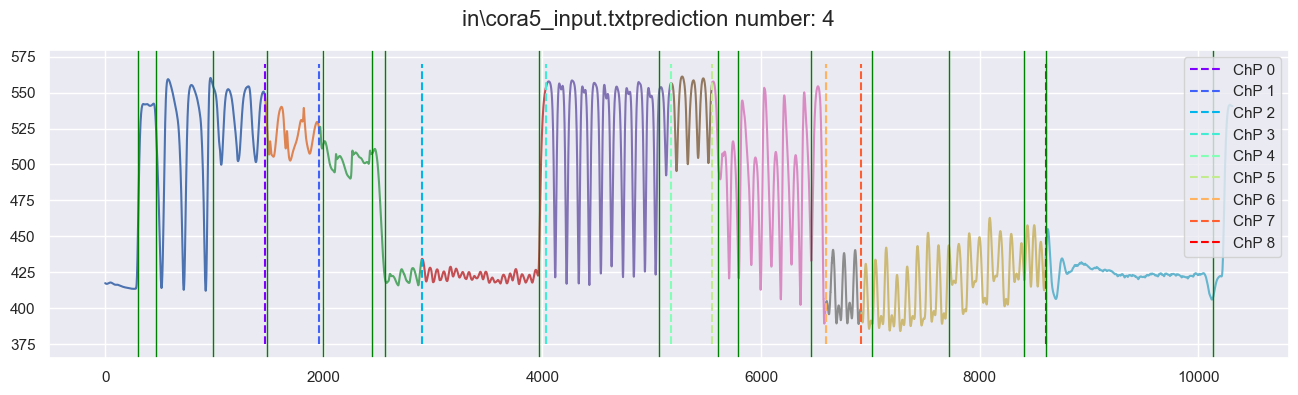

In [10]:
# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df)

unknown!
accuracy, precision, recall, f1: (0.9968010856921288, 0.0, 0.0, 0.0)


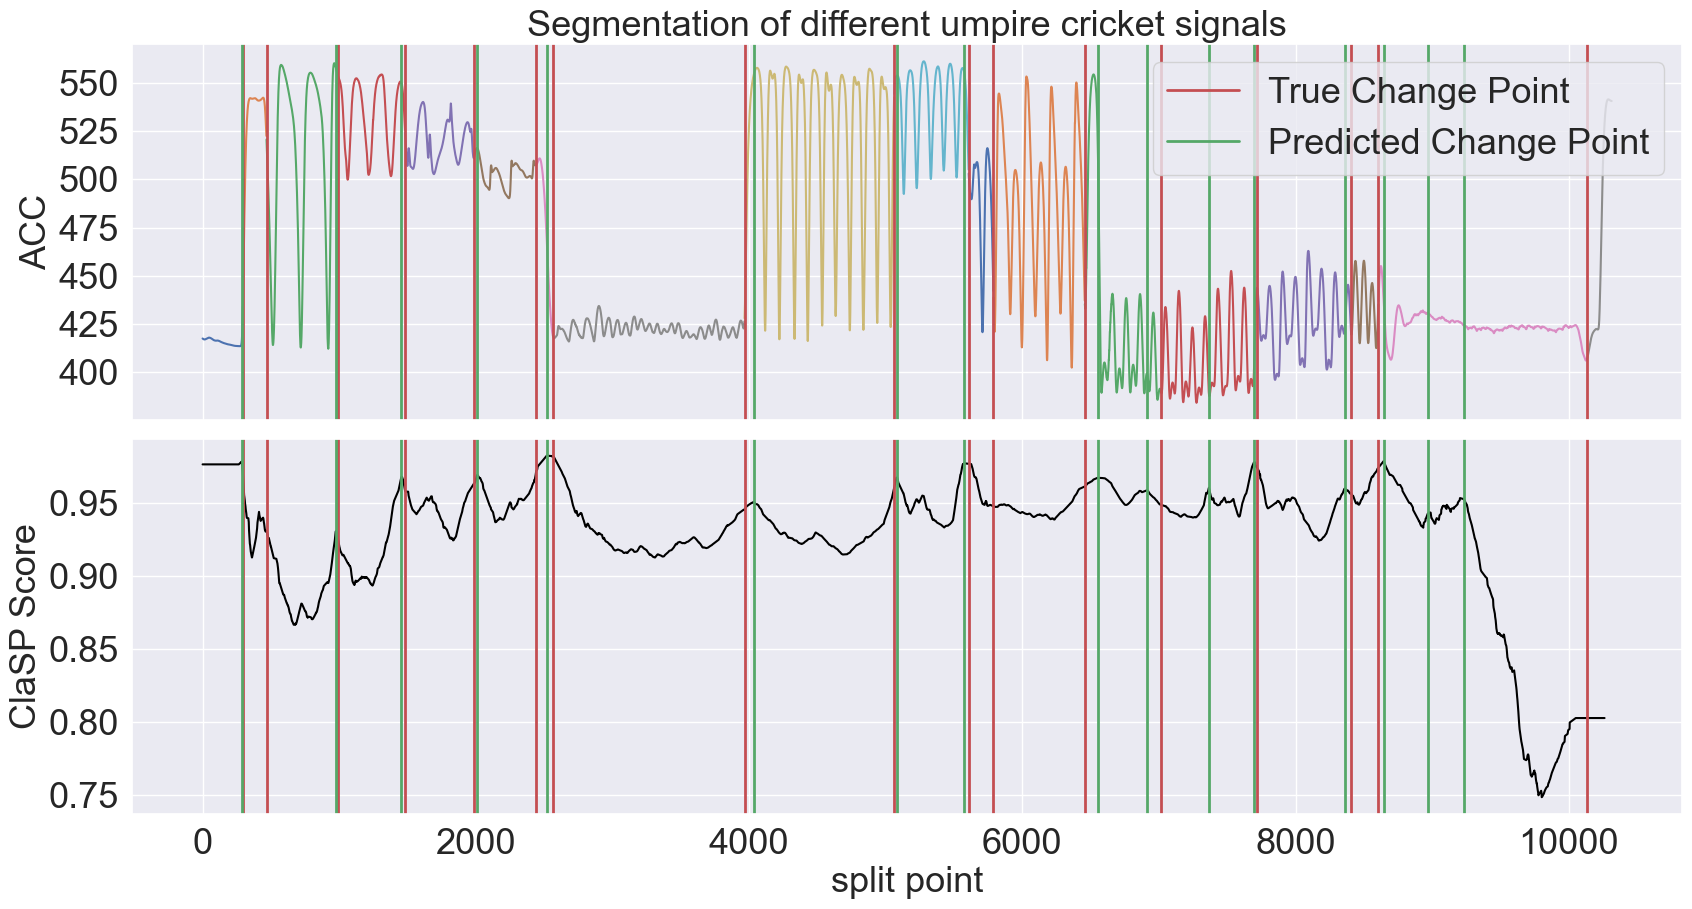

In [11]:
# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,n_segments=17, validation=None, window_size="suss",distance="euclidean_distance")
    Plotclasp(clasp,gt)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df)

In [34]:
f_measure({1:[10000]},[0])

0.6666666666666666

In [38]:
gt

array([  296.24300325,   468.54760719,   990.4995653 ,  1483.23027479,
        1989.96703103,  2441.48570368,  2564.41647374,  3967.03640751,
        5063.03475662,  5608.06142485,  5789.53545507,  6458.90357432,
        7015.41721615,  7716.42489426,  8409.67382704,  8607.7737401 ,
       10134.23131026])

In [39]:
cp

array([  288.,   981.,  1460.,  2013.,  2520.,  4021.,  5084.,  5575.,
        6553.,  6918.,  7348.,  7697.,  8644.,  8968.,  9237., 10066.])

unknown!
accuracy, precision, recall, f1: (0.9968010856921288, 0.0, 0.0, 0.0)
f-measure: 0.05714285714285714
f-measureasd: 1.0
covering: 0.14551623848763937


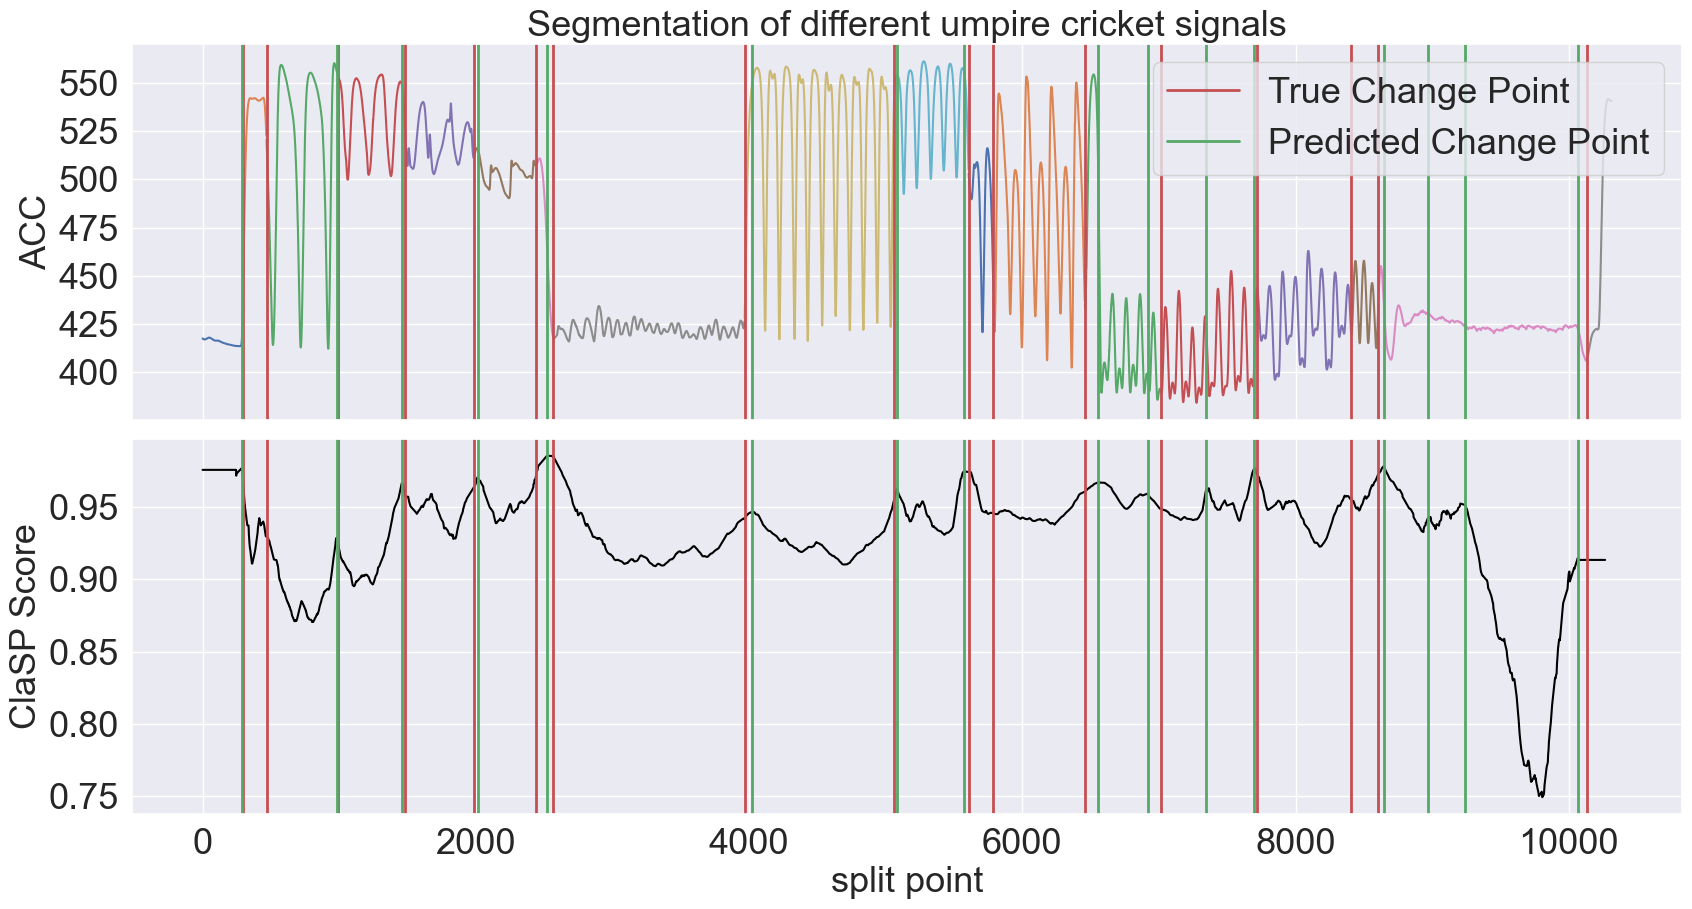

In [37]:
# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,n_segments=17, validation=None, window_size="fft",distance="euclidean_distance")
    Plotclasp(clasp,gt)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df)

unknown!
accuracy, precision, recall, f1: (0.9968010856921288, 0.0, 0.0, 0.0)


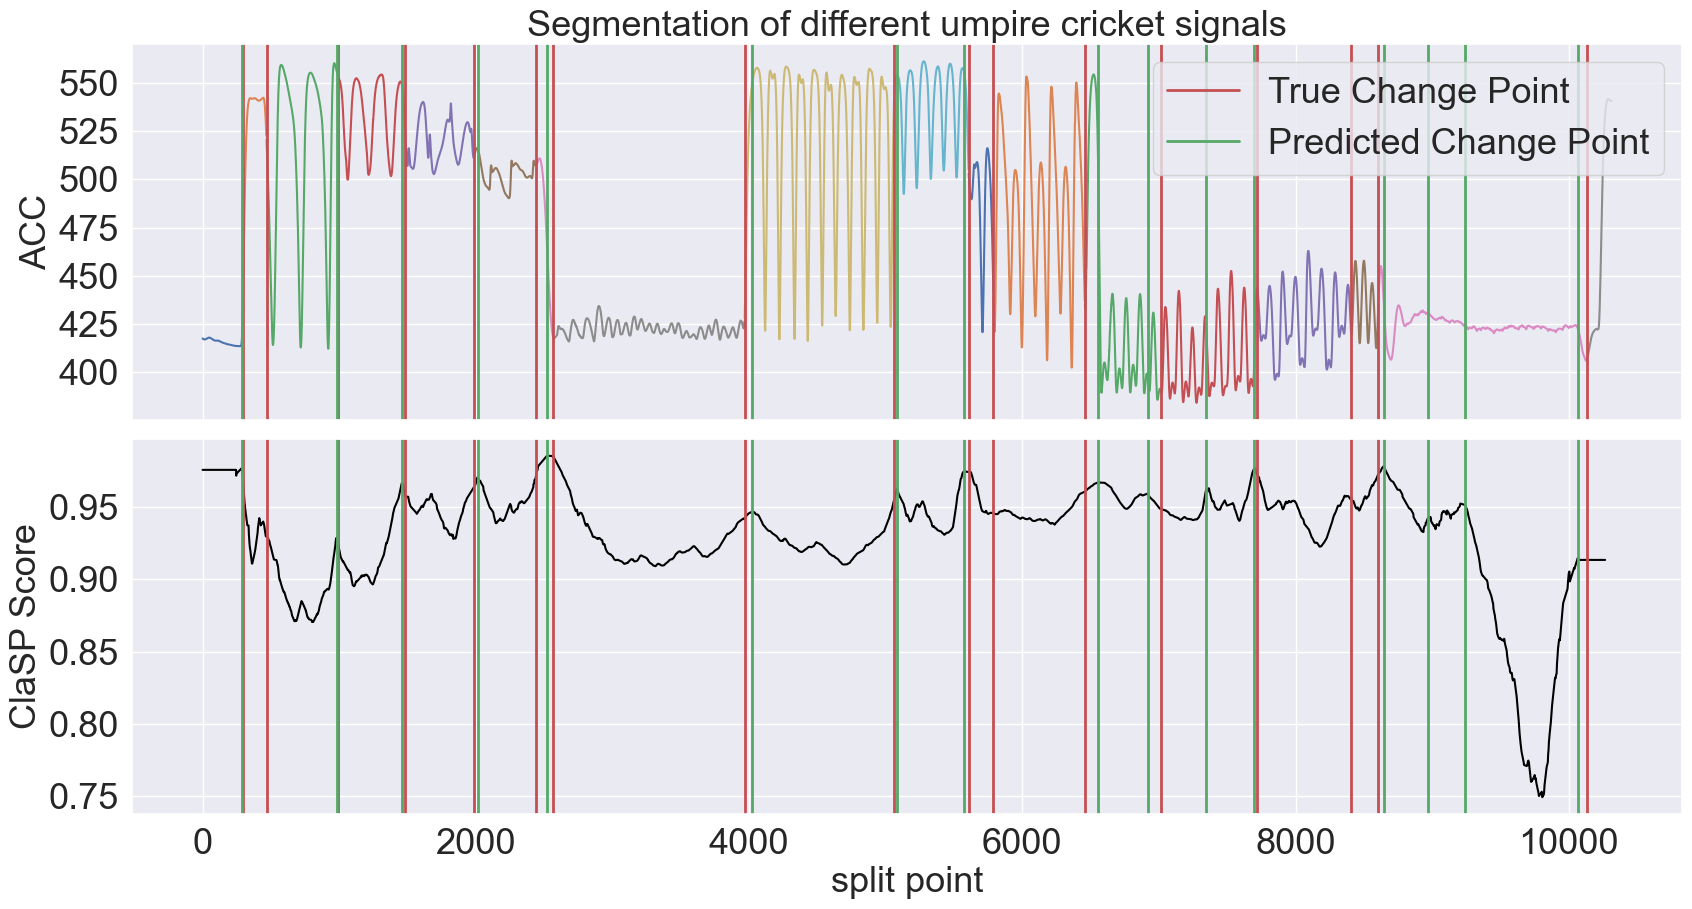

In [13]:
# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,n_segments=17, validation=None, window_size="acf",distance="euclidean_distance")
    Plotclasp(clasp,gt)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df)